# 타이타닉 분석

## 1. 소개

### 1.1 데이터 설명
* train.csv : 예측 모델을 만들기 위해 사용하는 학습 데이터다. 탑승객의 신상정보와 생존유무가 주어진다. <br />
* test.csv - 학습 데이터에서 신상정보 및 파생변수를 토대로 모델을 만들고 test.csv파일을 이용하여 생존유무를 예측한다. <br />
* sampleSubmission.csv - 제출시 사용하는 csv 파일이다. <br />

### 1.2 변수 설명
* survival : 생존유무, target 값. (0 = 사망, 1 = 생존) <br />
* pclass : 티켓 클래스. (1 = 1st, 2 = 2nd, 3 = 3rd) <br />
* sex : 성별 <br />
* Age : 나이(세) <br />
* sibsp : 함께 탑승한 형제자매, 배우자 수 총합 <br />
* parch : 함께 탑승한 부모, 자녀 수 총합 <br />
* ticket : 티켓 넘버 <br />
* fare : 탑승 요금 <br />
* cabin : 객실 넘버 <br />
* embarked : 탑승 항구

## 2. 준비작업
### 2.1 Packages

In [1]:
library(readr)
library(stringr) # 문자열 처리 패키지
library(doBy)
library(ggplot2)
library(scales)
library(RColorBrewer)
library(corrplot)
library(doBy)
library(dplyr) # 전처리
library(randomForest)
library(gridExtra)


Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor

corrplot 0.84 loaded

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘gridExtra’

The following object is masked from ‘package:randomForest’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



### 2.2 Loading the data

read.csv()보다 readr 패키지의 read_csv()가 조금 더 빨리 데이터를 읽어온다는 장점이 있다.<br />
그러나 read_csv()는 stringsAsFactors 옵션이 없어서 문자열(Character)과 요인(Factor)를 구별하지 못하고 모두 Character로 불러온다.<br />

추가적으로 R에서 기본 내장함수 rbind()는 두 데이터의 차원이 같을 때 병합할 수 있는데 test셋에는 Y값이 없어서 차원이 다르다.<br />
이에 따라 dplyr::bind_rows()를 사용하여 test데이터의 Y값은 NA처리하며 병합한다.


In [2]:
train <- read_csv('../input/train.csv')
test <- read_csv('../input/test.csv')
full <- bind_rows(train, test)

full <- full %>% # ticket과 cabin은 파생변수 생성을 위해 문자열로 놔둠
  mutate(Survived = factor(Survived),
         Pclass   = factor(Pclass, ordered = T),
         Name     = factor(Name),
         Sex      = factor(Sex),
         Embarked = factor(Embarked))

str(full)

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)
Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)


Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: num  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 156 287 531 430 23 826 775 922 613 855 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  NA "C85" NA "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


# 3. 탐색적 데이터 분석(EDA)

## 3.1 수치값을 활용한 data 확인

In [3]:
head(full)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


In [4]:
str(full)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: num  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 156 287 531 430 23 826 775 922 613 855 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  NA "C85" NA "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


In [5]:
summary(full)

  PassengerId   Survived   Pclass                                Name     
 Min.   :   1   0   :549   1:323   Connolly, Miss. Kate            :   2  
 1st Qu.: 328   1   :342   2:277   Kelly, Mr. James                :   2  
 Median : 655   NA's:418   3:709   Abbing, Mr. Anthony             :   1  
 Mean   : 655                      Abbott, Master. Eugene Joseph   :   1  
 3rd Qu.: 982                      Abbott, Mr. Rossmore Edward     :   1  
 Max.   :1309                      Abbott, Mrs. Stanton (Rosa Hunt):   1  
                                   (Other)                         :1301  
     Sex           Age            SibSp            Parch      
 female:466   Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 male  :843   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000  
              Median :28.00   Median :0.0000   Median :0.000  
              Mean   :29.88   Mean   :0.4989   Mean   :0.385  
              3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000  
              Max.   :

1. 사망자가 생존자보다 많다 <br />
2. 남성이 여성보다 2배 가까이 더 많다 <br />
3. SibSp의 3분위값이 1이므로 대부분 부부끼리 혹은 형제끼리 탑승했다 <br />
4. Parch의 3분위수가 0이므로 부모나 자녀와 함께 탑승한 승객이 많지 않다 <br />
5. Fare의 최대값이 512로 이상치가 아닌지 확인이 필요해 보인다 <br />
6. 결측치가 많은 데이터임을 확인할 수있다. <br />

In [6]:
sapply(train, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
        891           2           3         891           2          89 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           7         681         248         148           4

## 3.2 결측치 확인 및 시각화

In [7]:
colSums(is.na(full))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2

In [8]:
missing_values <- full %>%      # 결측치 비율을 데이터프레임으로
  dplyr::summarize_all(funs(sum(is.na(.))/n()))

# tidyr::gather()함수를 이용하여 stack화 시킴 (설명변수들이 key로 지정한 변수에 나열되고, 결측값들이 value로 지정한 변수의 값으로)
missing_values <- tidyr::gather(missing_values,
                                key = "feature", value = "missing_pct")
missing_values

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”

feature,missing_pct
PassengerId,0.0000000000
Survived,0.3193277311
Pclass,0.0000000000
Name,0.0000000000
Sex,0.0000000000
Age,0.2009167303
SibSp,0.0000000000
Parch,0.0000000000
Ticket,0.0000000000
Fare,0.0007639419


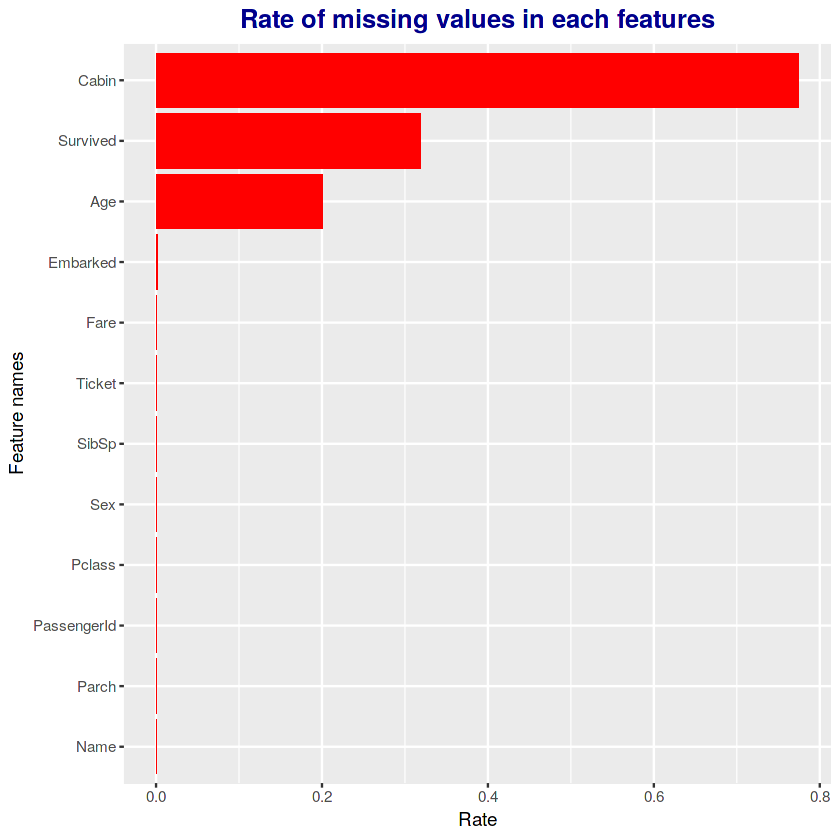

In [9]:
missing_values %>% 
  ggplot(aes(x = reorder(feature, missing_pct), y = missing_pct)) + # 정렬을 위한 reorder() 축지정
  geom_bar(stat = "identity", fill = "red") +  # bar plot 그리기 stat = 'identity' 데이터프레임 값을 그대로 이용하여 그리라는 옵션
  ggtitle("Rate of missing values in each features") +
  theme(plot.title = element_text(face = "bold",    # 글씨체 
                                  hjust = 0.5,      # Horizon(가로비율) = 0.5
                                  size = 15, color = "darkblue")) +
  labs(x = "Feature names", y = "Rate") +  # x,y축 제목 지정
  coord_flip() # Plot의 x, y축 변환 

# 결측값이 있는 변수로만 시각화
missing_values <- missing_values[missing_values$missing_pct > 0, ]

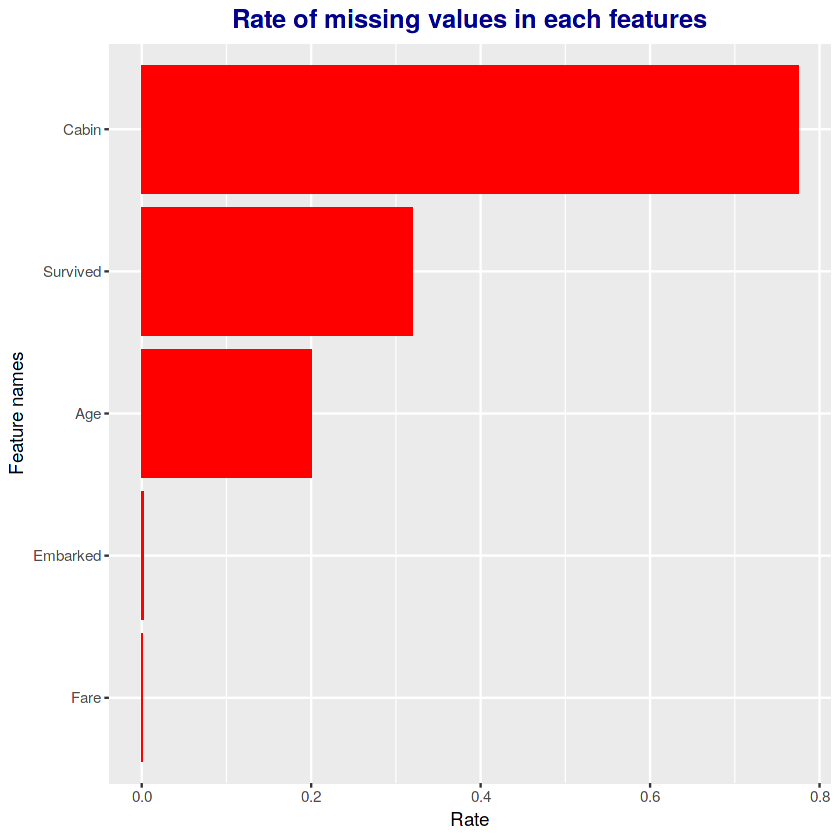

In [10]:
missing_values <- missing_values[missing_values$missing_pct > 0, ]

missing_values %>% 
  ggplot(aes(x = reorder(feature, missing_pct), y = missing_pct)) + # 정렬을 위한 reorder() 축지정
  geom_bar(stat = "identity", fill = "red") +  # bar plot 그리기 stat = 'identity' 데이터프레임 값을 그대로 이용하여 그리라는 옵션
  ggtitle("Rate of missing values in each features") +
  theme(plot.title = element_text(face = "bold",    # 글씨체 
                                  hjust = 0.5,      # Horizon(가로비율) = 0.5
                                  size = 15, color = "darkblue")) +
  labs(x = "Feature names", y = "Rate") +  # x,y축 제목 지정
  coord_flip() # Plot의 x, y축 변환 

## 3.3 변수 EDA

### 3.3.1 Sex

In [11]:
table(full$Sex)


female   male 
   466    843 

In [12]:
full %>% group_by(Survived, Sex) %>% summarise(freq = n())

Warning message:
“Factor `Survived` contains implicit NA, consider using `forcats::fct_explicit_na`”

Survived,Sex,freq
0,female,81
0,male,468
1,female,233
1,male,109
NA,female,152
NA,male,266


In [13]:
prop.table(table(full$Sex,full$Survived),1) #여자들이 생존할 확률이 높음

        
                 0         1
  female 0.2579618 0.7420382
  male   0.8110919 0.1889081

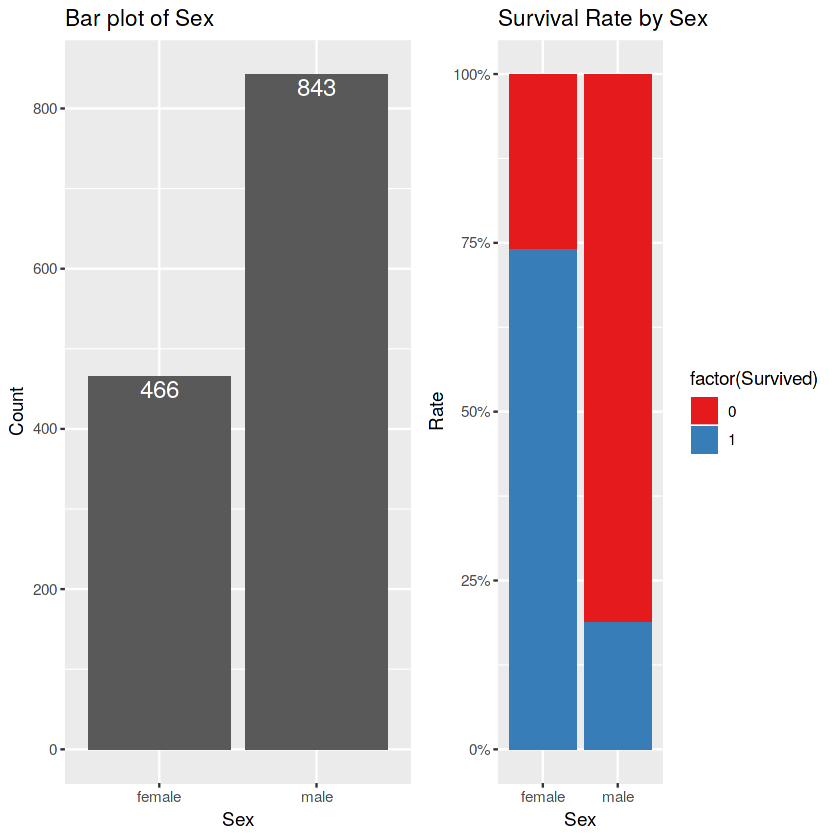

In [14]:
# 성별 막대그래프
sex.p1 <- full %>% 
  dplyr::group_by(Sex) %>% 
  summarize(N = n()) %>% 
  ggplot(aes(Sex, N)) +
  geom_col() +
  geom_text(aes(label = N), size = 5, vjust = 1.2, color = "#FFFFFF") + 
  ggtitle("Bar plot of Sex") +
  labs(x = "Sex", y = "Count")

# 성별에 따른 생존률 막대그래프
sex.p2 <- full%>%
  filter(!is.na(Survived)) %>%
  ggplot(aes(factor(Sex), fill = factor(Survived))) +
  geom_bar(position = "fill") + 
  scale_y_continuous(labels = percent) +
  scale_fill_brewer(palette = "Set1") +  # palette에 어떤색 넣을지 지정
   # 일정한 간격으로 x축과 y축 설정 : scale_x_continuous(breaks=seq())
  # 분석가 마음대로 x축과 y축 설정 : scale_x_continuous(breaks=c())
  ggtitle("Survival Rate by Sex") + 
  labs(x = "Sex", y = "Rate")

grid.arrange(sex.p1,sex.p2,ncol=2)

### 3.3.2 Pclass

In [15]:
table(full$Pclass)


  1   2   3 
323 277 709 

In [16]:
prop.table(table(full$Pclass,full$Survived),1) # 더 좋은 객실 이용자일수록 생존할 확률이 높음

   
            0         1
  1 0.3703704 0.6296296
  2 0.5271739 0.4728261
  3 0.7576375 0.2423625

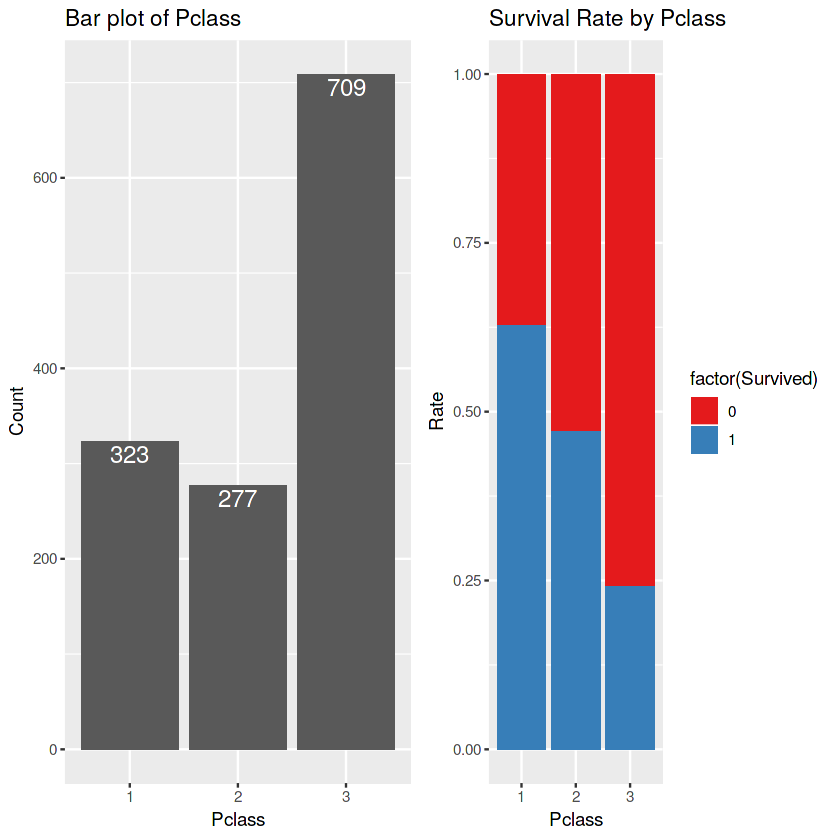

In [17]:
# Pclass 막대그래프
pclass.p1 <- full %>% 
  dplyr::group_by(Pclass) %>% 
  summarize(N = n()) %>% 
  ggplot(aes(Pclass, N)) +
  geom_col() +
  geom_text(aes(label = N), size = 5, vjust = 1.2, color = "#FFFFFF") + 
  ggtitle("Bar plot of Pclass") +
  labs(x = "Pclass", y = "Count")

# Pclass에 따른 생존률 막대그래프
pclass.p2 <- full%>%
  filter(!is.na(Survived)) %>%
  ggplot(aes(factor(Pclass), fill = factor(Survived))) +
  geom_bar(position = "fill") + 
  scale_fill_brewer(palette = "Set1") +  
  ggtitle("Survival Rate by Pclass") + 
  labs(x = "Pclass", y = "Rate")

grid.arrange(pclass.p1,pclass.p2,ncol=2)

### 3.3.3 Fare

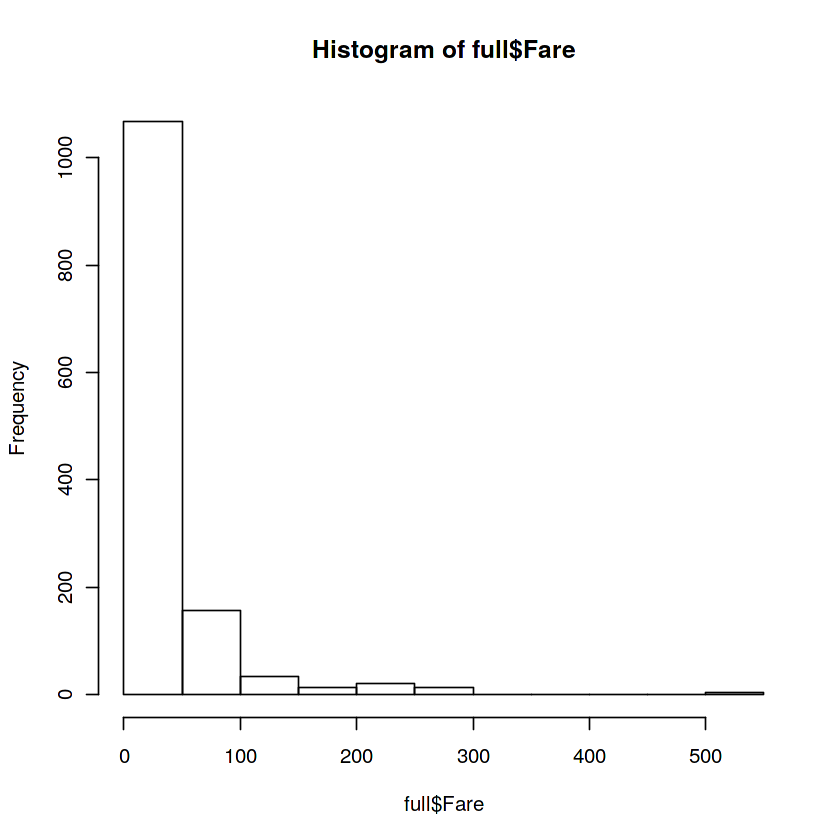

In [18]:
hist(full$Fare)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

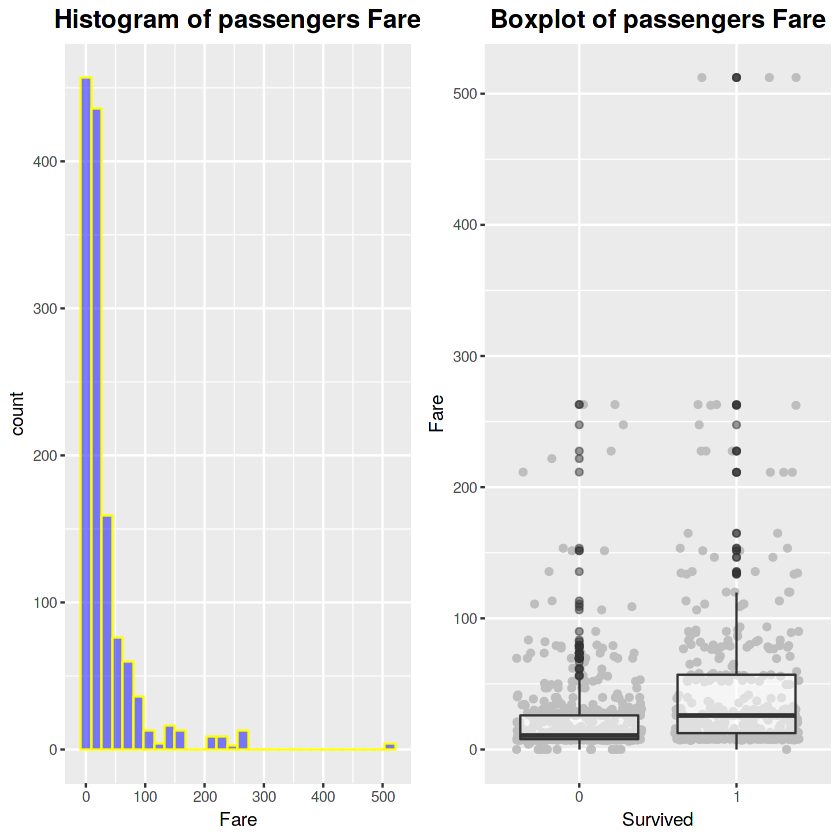

In [19]:
# fare 히스토그램
Fare.p1 <- full %>%
  ggplot(aes(Fare)) + 
  geom_histogram(col    = "yellow",
                 fill   = "blue", 
                 alpha  = .5) +
  ggtitle("Histogram of passengers Fare") +
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 15))

# 생존여부에 따른 fare box plot
Fare.p2 <- full %>%
  filter(!is.na(Survived)) %>% 
  ggplot(aes(Survived, Fare)) +  # x축에 생존 y축에 fare
  # 관측치를 회색점으로 찍되, 중복되는 부분은 퍼지게 그려줍니다.
  geom_jitter(col = "gray") + 
  # 상자그림 : 투명도 50% 
  geom_boxplot(alpha = .5) + 
  ggtitle("Boxplot of passengers Fare") +
  theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 15))

grid.arrange(Fare.p1,Fare.p2,ncol=2)

### 3.3.4 Age

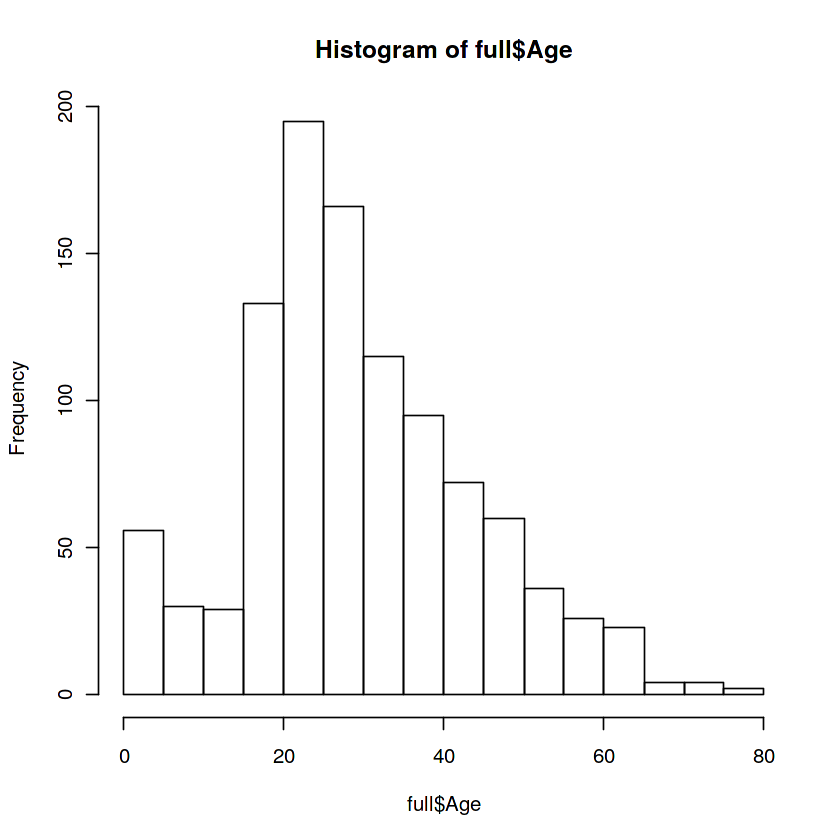

In [20]:
hist(full$Age)

Warning message:
“Removed 263 rows containing non-finite values (stat_bin).”Warning message:
“Removed 177 rows containing non-finite values (stat_density).”

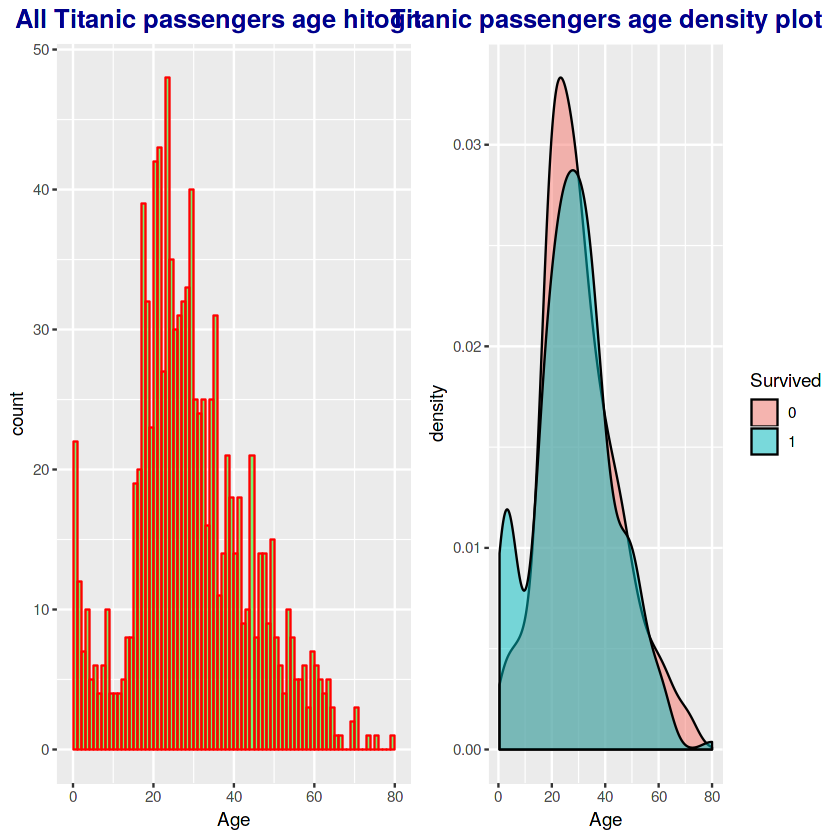

In [21]:
# 나이 분포 히스토그램
age.p1 <- full %>% 
  ggplot(aes(Age)) +     # x값에 따른 y값을 그리는 것이 아니므로 축 지정 안해줘도 됨 
  # 히스토그램 그리기, 설정
  geom_histogram(breaks = seq(0, 80, by = 1), # 간격 설정 
                 col    = "red",              # 막대 경계선 색깔 
                 fill   = "green",            # 막대 내부 색깔 
                 alpha  = .5) +               # 막대 투명도 = 50% 
  # Plot title
  ggtitle("All Titanic passengers age hitogram") +
  theme(plot.title = element_text(face = "bold",    # 글씨체 
                                  hjust = 0.5,      # Horizon(가로비율) = 0.5
                                  size = 15, color = "darkblue"))

# 나이에 따른 생존 분포 파악
age.p2 <- full %>% 
  filter(!is.na(Survived)) %>%
  ggplot(aes(Age, fill = Survived)) + 
  geom_density(alpha = .5) +   # 막대그래프가 아니고 밀도그래프니까 plot으로 축 지정하고 geom_bar 대신에 geom_density
  ggtitle("Titanic passengers age density plot") + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5,
                                  size = 15, color = "darkblue"))

grid.arrange(age.p1,age.p2,ncol=2)

### 3.3.5 Sibsp

In [22]:
table(full$SibSp)


  0   1   2   3   4   5   8 
891 319  42  20  22   6   9 

In [23]:
train %>% group_by(Survived, SibSp) %>% summarise(freq = n())

Survived,SibSp,freq
0,0,398
0,1,97
0,2,15
0,3,12
0,4,15
0,5,5
0,8,7
1,0,210
1,1,112
1,2,13


In [24]:
prop.table(table(train$SibSp,train$Survived),1) #배우자,형제자매가 많을수록 생존률이 떨어짐

   
            0         1
  0 0.6546053 0.3453947
  1 0.4641148 0.5358852
  2 0.5357143 0.4642857
  3 0.7500000 0.2500000
  4 0.8333333 0.1666667
  5 1.0000000 0.0000000
  8 1.0000000 0.0000000

### 3.3.6 Parch

In [25]:
table(train$Parch)


  0   1   2   3   4   5   6 
678 118  80   5   4   5   1 

In [26]:
train %>% group_by(Survived, Parch) %>% summarise(freq = n())

Survived,Parch,freq
0,0,445
0,1,53
0,2,40
0,3,2
0,4,4
0,5,4
0,6,1
1,0,233
1,1,65
1,2,40


In [27]:
prop.table(table(train$Parch,train$Survived),1) #부모와 자녀를 1~3명 정도 동승했을 경우 생존률이 높음 

   
            0         1
  0 0.6563422 0.3436578
  1 0.4491525 0.5508475
  2 0.5000000 0.5000000
  3 0.4000000 0.6000000
  4 1.0000000 0.0000000
  5 0.8000000 0.2000000
  6 1.0000000 0.0000000

### 3.3.7 Embarked

In [28]:
table(train$Embarked) #결측값 2개


  C   Q   S 
168  77 644 

In [29]:
train %>% group_by(Survived, Embarked) %>% summarise(freq = n())

Survived,Embarked,freq
0,C,75
0,Q,47
0,S,427
1,NA,2
1,C,93
1,Q,30
1,S,217


In [30]:
prop.table(table(train$Embarked,train$Survived),1) # C에서 탑승한 인원들만 생존률이 더 높다

   
            0         1
  C 0.4464286 0.5535714
  Q 0.6103896 0.3896104
  S 0.6630435 0.3369565

# 4. 결측치 처리

3.2 EDA 과정에서 결측치가 Cabin에 1014개, Age에 263개, Embarked 2개, Fare에 1개 존재한다는 것을 확인했다<br />
Cabin은 결측치 수가 너무 많아서 그냥 변수를 제거하고, 차후 파생병수 Deck을 생성할 것이다<br />
따라서 Cabin 변수를 제외한 나머지 변수들에 대한 결측치 처리를 수행하려 한다<br />

Age 결측처리는 5.feature engineering 과정에서 생성한 파생변수 title을 이용하여 처리하기 위해 5.4 Age feature engineering 과정에서 결측처리를 병행하도록 한다<br />

따라서 해당 절에서는 Embarked 와 Fare의 결측처리를 우선 수행한다

In [31]:
colSums(is.na(full))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2

## 4.1 Embarked 결측처리

In [32]:
full[is.na(full$Embarked), ] #두개의 관측치 모두 Fare가 80이고, Pclass가 1임

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NA
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NA


In [33]:
embark_fare <- full[!is.na(full$Embarked), ]

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

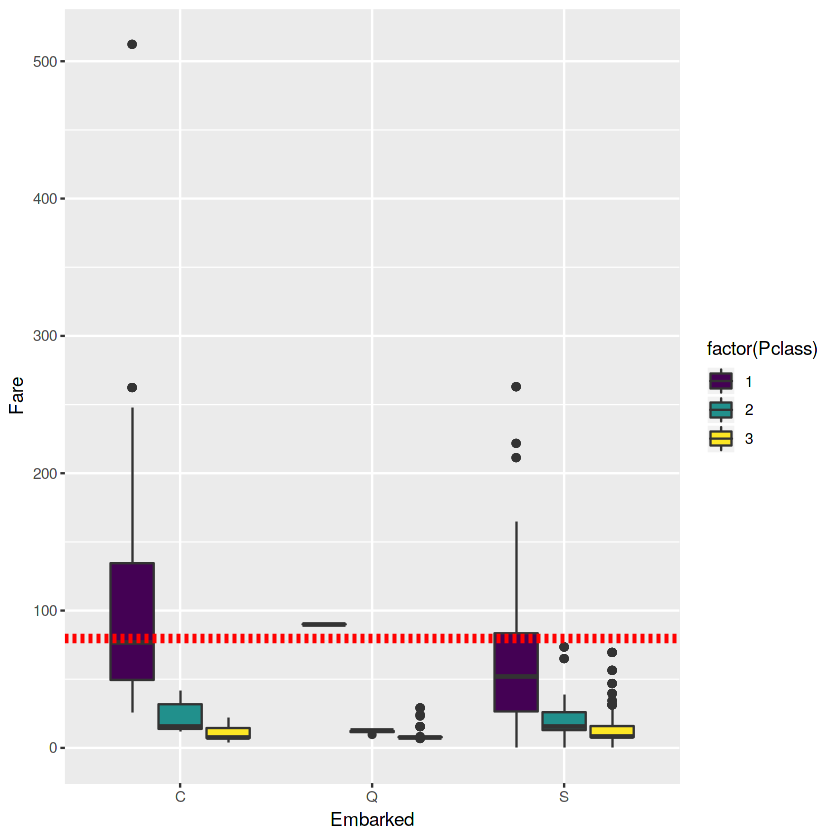

In [34]:
ggplot(embark_fare, aes(x = Embarked, y = Fare, fill = factor(Pclass))) +
  geom_boxplot() +
  geom_hline(aes(yintercept=80), # fare가 80에 line 생성
             colour='red', linetype='dashed', lwd=2) +
  scale_y_continuous()

fare가 80면서 Pclass가 1인 승객들 대다수는 Embark가 C다

In [35]:
full$Embarked[c(62, 830)] <- 'C'
full[c(62, 830),] 

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,C
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,C


## 4.2 Fare 결측처리

In [36]:
full  %>% filter(is.na(full$Fare)) #Pclasss가 3이고, Embarked는 S임

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,NA,S


In [37]:
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE) #중앙값으로 결측치 처리
full[1044,]

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,NA,S


# 5. Feature engineering

## 5.1 Name

Name에서 성별과 관련된 이름만을 추출하고 범주화해서 Title 파생변수를 생성한다

In [38]:
Title <- full$Name
Title <- gsub("^.*, (.*?)\\..*$", "\\1", Title) # 정규표현식
full$Title <- Title
unique(full$Title)

[1] "Mr"           "Mrs"          "Miss"         "Master"       "Don"         
 [6] "Rev"          "Dr"           "Mme"          "Ms"           "Major"       
[11] "Lady"         "Sir"          "Mlle"         "Col"          "Capt"        
[16] "the Countess" "Jonkheer"     "Dona"

이 title이라는 파생변수를 그대로 사용할 경우 모델의(특히 Tree based model) 복잡도가 상당히 높아지기 때문에 범주를 줄여줘야한다.
그 전에 descr패키지를 이용해서 각 범주별 빈도수와 비율을 확인해보겠다

In [39]:
# 범주별 빈도수, 비율 확인 
descr::CrossTable(full$Title)

   Cell Contents 
|-------------------------|
|                       N | 
|           N / Row Total | 
|-------------------------|

|         Capt |          Col |          Don |         Dona |           Dr |
|--------------|--------------|--------------|--------------|--------------|
|            1 |            4 |            1 |            1 |            8 |
|        0.001 |        0.003 |        0.001 |        0.001 |        0.006 |
|--------------|--------------|--------------|--------------|--------------|

|     Jonkheer |         Lady |        Major |       Master |         Miss |
|--------------|--------------|--------------|--------------|--------------|
|            1 |            1 |            2 |           61 |          260 |
|        0.001 |        0.001 |        0.002 |        0.047 |        0.199 |
|--------------|--------------|--------------|--------------|--------------|

|         Mlle |          Mme |           Mr |          Mrs |           Ms |
|--------------|--

In [40]:
# 5개 범주로 단순화 시키는 작업 
full <- full %>%
  # "%in%" 대신 "=="을 사용하게되면 Recyling Rule 때문에 원하는대로 되지 않습니다.
  mutate(Title = ifelse(Title %in% c("Mlle", "Ms", "Lady", "Dona"), "Miss", Title), # %in% 개념
         Title = ifelse(Title == "Mme", "Mrs", Title),
         Title = ifelse(Title %in% c("Capt", "Col", "Major", "Dr", "Rev", "Don",
                                     "Sir", "the Countess", "Jonkheer"), "Officer", Title),
         Title = factor(Title))

In [41]:
# 파생변수 생성 후 각 범주별 빈도수, 비율 확인 
descr::CrossTable(full$Title) # 5개의 범주로 축소

   Cell Contents 
|-------------------------|
|                       N | 
|           N / Row Total | 
|-------------------------|

|  Master |    Miss |      Mr |     Mrs | Officer |
|---------|---------|---------|---------|---------|
|      61 |     266 |     757 |     198 |      27 |
|   0.047 |   0.203 |   0.578 |   0.151 |   0.021 |
|---------|---------|---------|---------|---------|


## 5.2 Sex

성별을 더미화한다

In [42]:
full$Sex <- ifelse(full$Sex == "male" ,0 , 1)
full$Sex <- as.factor(full$Sex)

## 5.3 Fsize

Sibsp와 Parch를 이용하여 Fsize 파생변수를 생성한다

In [43]:
full$Fsize <- full$SibSp + full$Parch + 1
table(full$Fsize)


  1   2   3   4   5   6   7   8  11 
790 235 159  43  22  25  16   8  11 

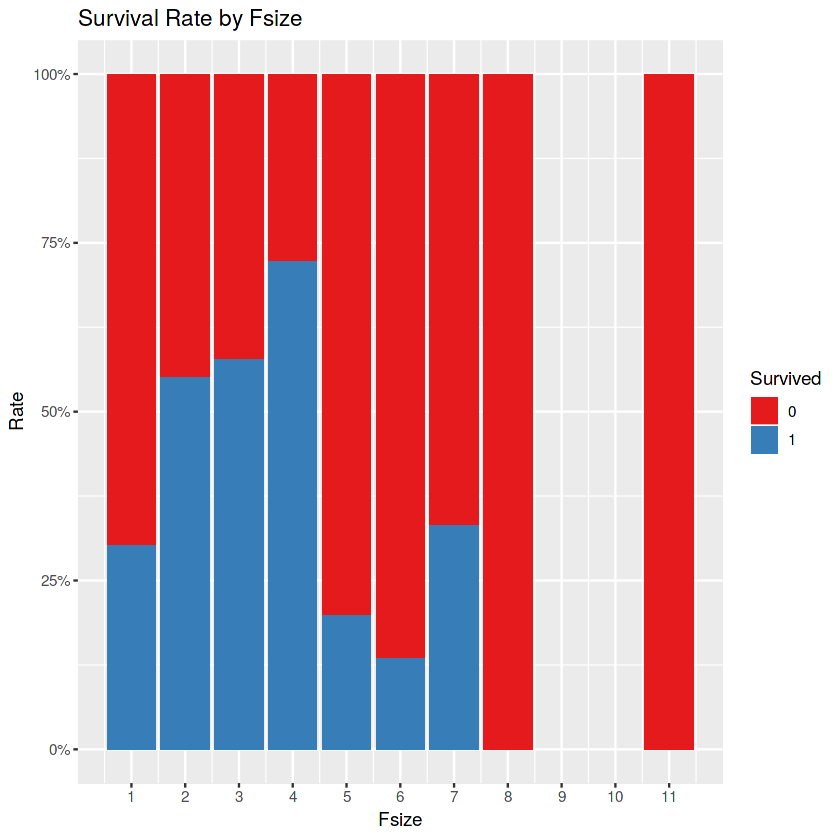

In [44]:
# Fsize에 따른 생존율 시각화
Fsize.p1 <- full%>%
  filter(!is.na(Survived)) %>%
  ggplot(aes(Fsize, fill = Survived)) +
  geom_bar(position = "fill") + 
  scale_y_continuous(labels = percent) +
  scale_x_continuous(breaks=c(1:11)) +
  scale_fill_brewer(palette = "Set1") +  # palette에 어떤색 넣을지 지정
  # 일정한 간격으로 x축과 y축 설정 : scale_x_continuous(breaks=seq())
  # 분석가 마음대로 x축과 y축 설정 : scale_x_continuous(breaks=c())
  ggtitle("Survival Rate by Fsize") + 
  labs(x = "Fsize", y = "Rate")

Fsize.p1



#ggplot(full[1:891,], aes(x = Fsize, fill = factor(Survived))) +
#  geom_bar(stat='count', position='fill') +   #position = 'dodge', 'fill' 구분
#  scale_x_continuous(breaks=c(1:11)) +
#  labs(x = 'Family Size', y = 'Rate') 


In [45]:
# 범주화
full$Familysize[full$Fsize == 1] <- 'single'
full$Familysize[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$Familysize[full$Fsize > 4] <- 'large'

full$Familysize <- as.factor(full$Familysize)
table(full$Familysize)

Warning message:
“Unknown or uninitialised column: 'Familysize'.”


 large single  small 
    82    790    437 

$x
[1] "Familysize"

$y
[1] "Rate"

attr(,"class")
[1] "labels"

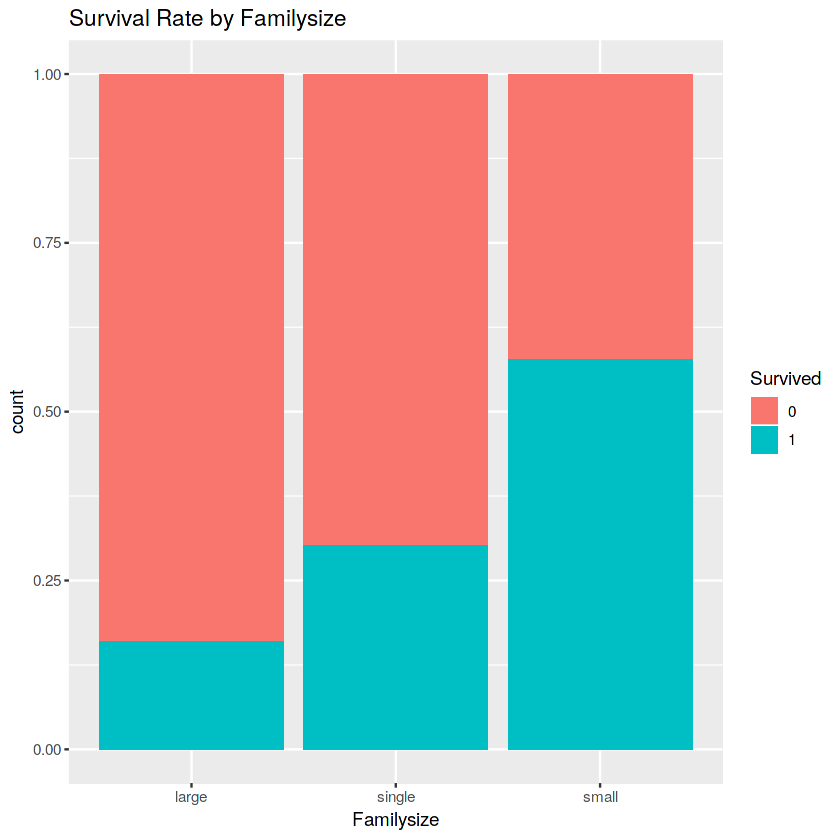

In [46]:
# 범주화 후 Familiysize에 따른 생존율 시각화
ggplot(full[1:891,], aes(x = Familysize, fill = Survived)) +
  geom_bar(position = 'fill') +
  ggtitle("Survival Rate by Familysize")
  labs(x="Familysize", y="Rate")


## 5.4 Cabin

In [47]:
full$Cabin[1:28]

[1] NA            "C85"         NA            "C123"        NA           
 [6] NA            "E46"         NA            NA            NA           
[11] "G6"          "C103"        NA            NA            NA           
[16] NA            NA            NA            NA            NA           
[21] NA            "D56"         NA            "A6"          NA           
[26] NA            NA            "C23 C25 C27"

In [48]:
strsplit(full$Cabin[2], NULL)[[1]]

[1] "C" "8" "5"

In [49]:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

In [50]:
full$Deck=as.character(full$Deck)
str(full)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  16 variables:
 $ PassengerId: num  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 156 287 531 430 23 826 775 922 613 855 ...
 $ Sex        : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  NA "C85" NA "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ Fsize      : num  2 2 1 2 1 1 1 5 3 2 ...
 $ Familysize : Factor w/ 3 levels "lar

In [51]:
#Cabin 변수 제거
full=full[,-11]

In [52]:
head(full)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Fsize,Familysize,Deck
1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,S,Mr,2,small,NA
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38,1,0,PC 17599,71.2833,C,Mrs,2,small,C
3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,S,Miss,1,single,NA
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,S,Mrs,2,small,C
5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,S,Mr,1,single,NA
6,0,3,"Moran, Mr. James",0,NA,0,0,330877,8.4583,Q,Mr,1,single,NA


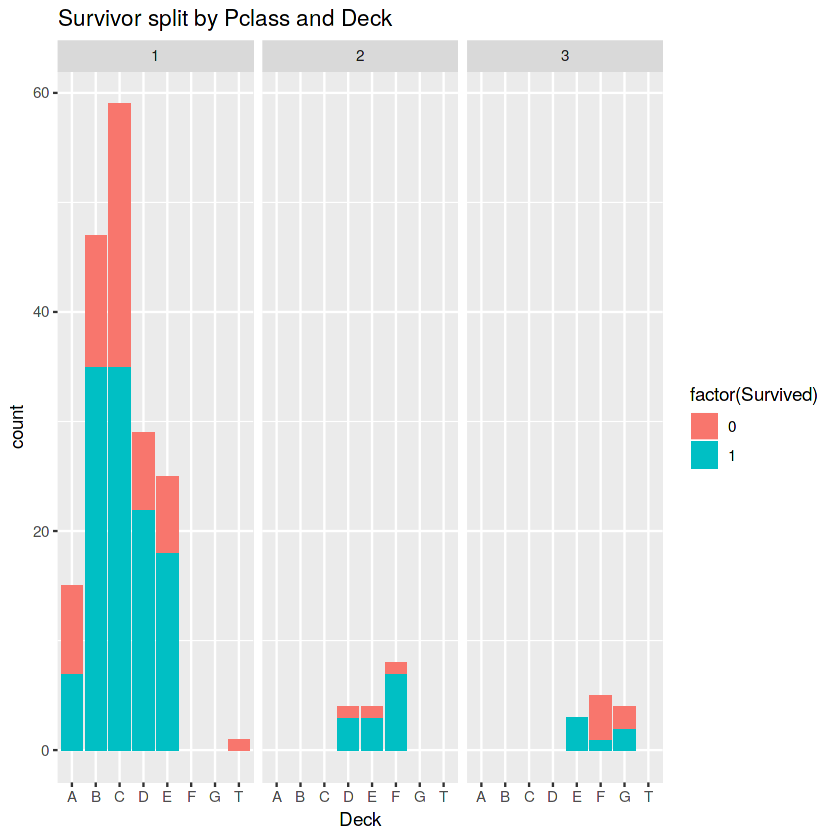

In [53]:
full$Deck[is.na(full$Deck)] <- "U"

cabin=full %>%filter(!is.na(full$Survived)& full$Deck!='U')

ggplot(cabin,aes(x=Deck, fill=factor(Survived), na.rm=TRUE)) +
        geom_bar(stat='count') +
        facet_grid(.~Pclass) +
        labs(title="Survivor split by Pclass and Deck")

In [54]:
full=full  %>% 
    mutate(Deck= ifelse(Pclass==1 & Deck=="U","X",
                        ifelse(Pclass==2 & Deck=="U","Y",
                               ifelse(Pclass==3 & Deck=="U","Z",Deck)))
          )

In [55]:
full  %>% count(Deck)

Deck,n
A,22
B,65
C,94
D,46
E,41
F,21
G,5
T,1
X,67
Y,254


## 5.5 Age

Age의 결측처리와 변수 가공을 수행한다

### 5.5.1 Age 결측처리

#### Sex에 따른 Age 탐색

Warning message:
“Removed 263 rows containing non-finite values (stat_density).”

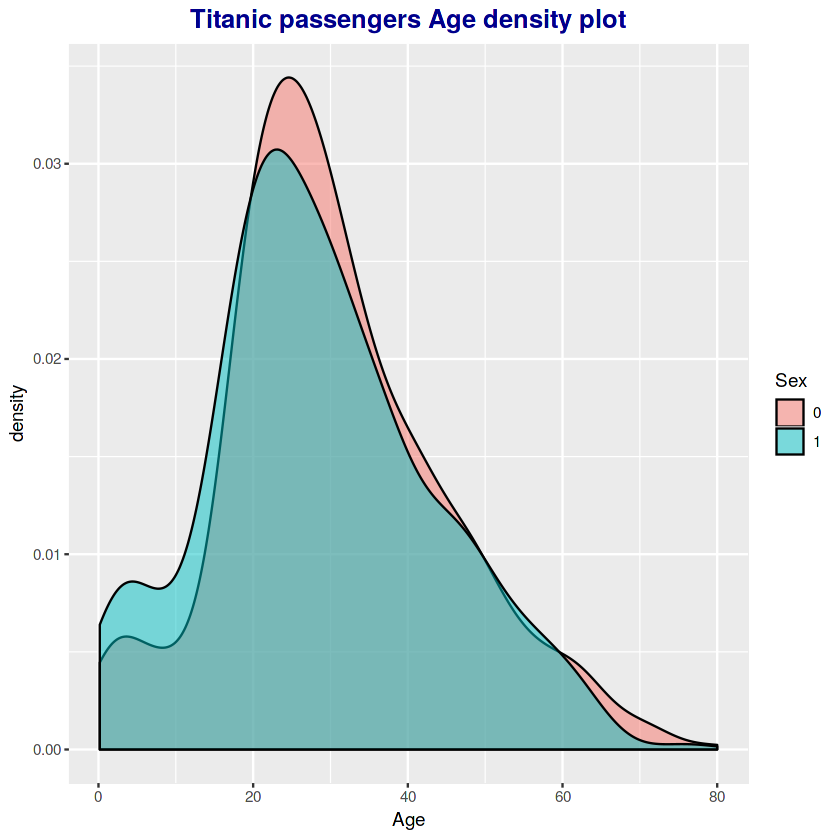

In [56]:
age.sex <- full %>% 
  ggplot(aes(Age, fill = Sex)) + 
  geom_density(alpha = .5) +  
  ggtitle("Titanic passengers Age density plot") + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5,
                                  size = 15, color = "darkblue"))
age.sex

#### Pclass에 따른 Age 탐색

Warning message:
“Removed 263 rows containing non-finite values (stat_density).”

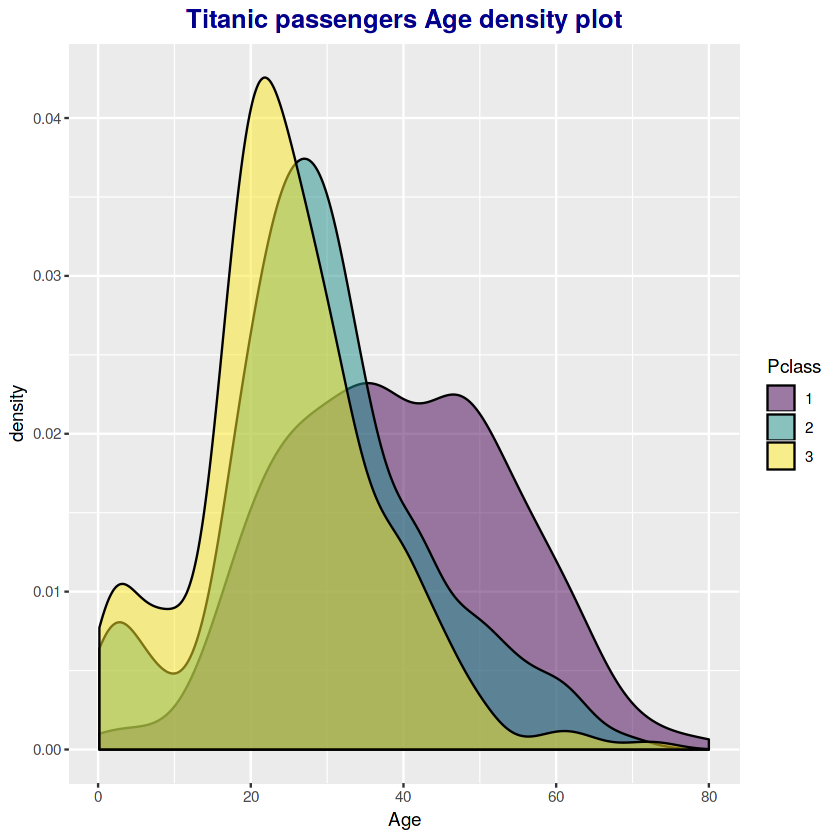

In [57]:
age.pclass <- full %>% 
  ggplot(aes(Age, fill = Pclass)) + 
  geom_density(alpha = .5) +  
  ggtitle("Titanic passengers Age density plot") + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5,
                                  size = 15, color = "darkblue"))
age.pclass

#### Title에 따른 Age 탐색

Warning message:
“Removed 263 rows containing non-finite values (stat_density).”

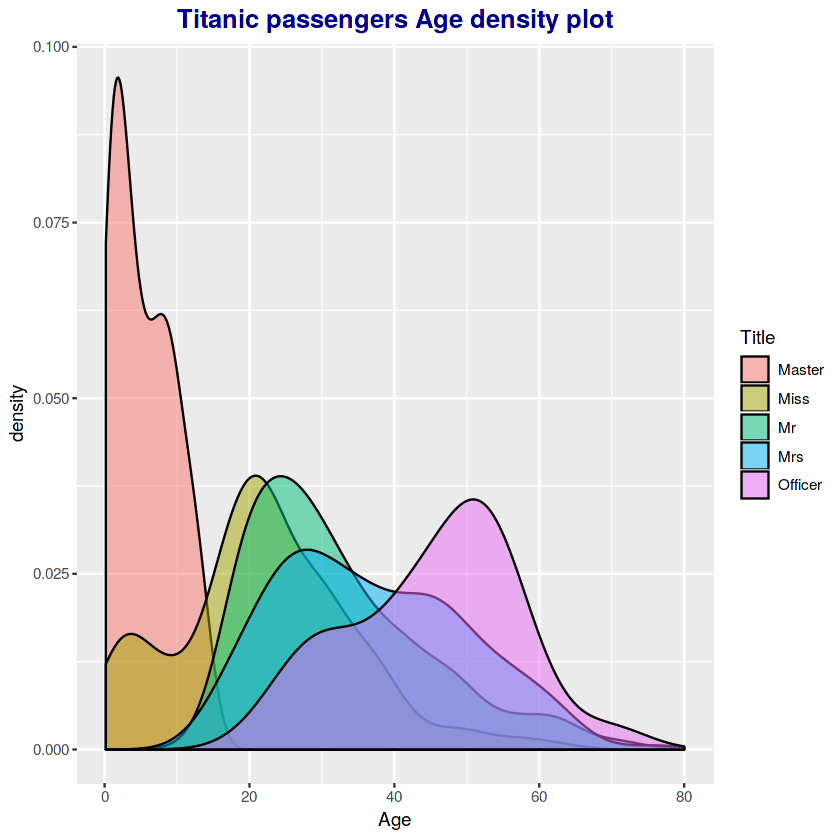

In [58]:
age.title <- full %>% 
  ggplot(aes(Age, fill = Title)) + 
  geom_density(alpha = .5) +  
  ggtitle("Titanic passengers Age density plot") + 
  theme(plot.title = element_text(face = "bold", hjust = 0.5,
                                  size = 15, color = "darkblue"))
age.title

title에 따른 결측처리 방법을 선택한다
각 분포가 정규분포라고 보기 힘드므로 중앙값을 사용한다

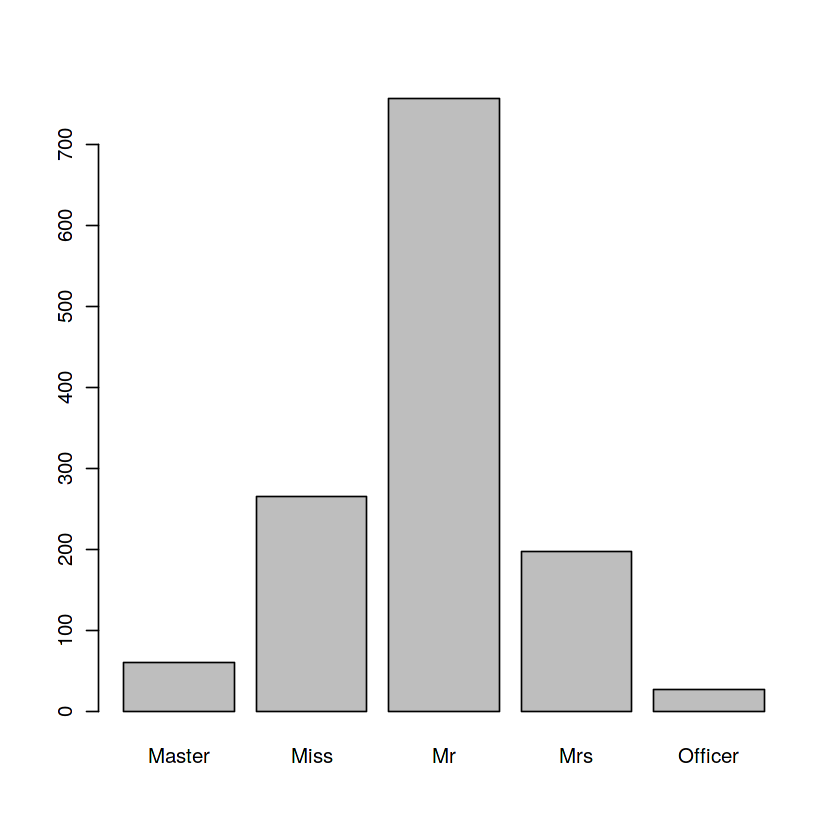

In [59]:
plot(full$Title)

In [60]:
# title별 Median Age를 통한 결측값 처리
full=as.data.frame(full)
summaryBy(Age ~ Title, data=full, FUN=c(mean, sd, median), na.rm=TRUE) ## ddply로도

Title,Age.mean,Age.sd,Age.median
Master,5.482642,4.161554,4
Miss,22.026000,12.300349,22
Mr,32.252151,12.422089,29
Mrs,36.918129,12.902087,35
Officer,45.307692,11.460434,48


In [61]:
full$Age <- ifelse((is.na(full$Age) & full$Title == 'Master'), 4, full$Age)
full$Age <- ifelse((is.na(full$Age) & full$Title == 'Miss'), 22, full$Age)
full$Age <- ifelse((is.na(full$Age) & full$Title == 'Mr'), 29, full$Age)
full$Age <- ifelse((is.na(full$Age) & full$Title == 'Mrs'), 35, full$Age)
full$Age <- ifelse((is.na(full$Age) & full$Title == 'Officer'), 48, full$Age)

### 5.5.2 Age 변수 가공

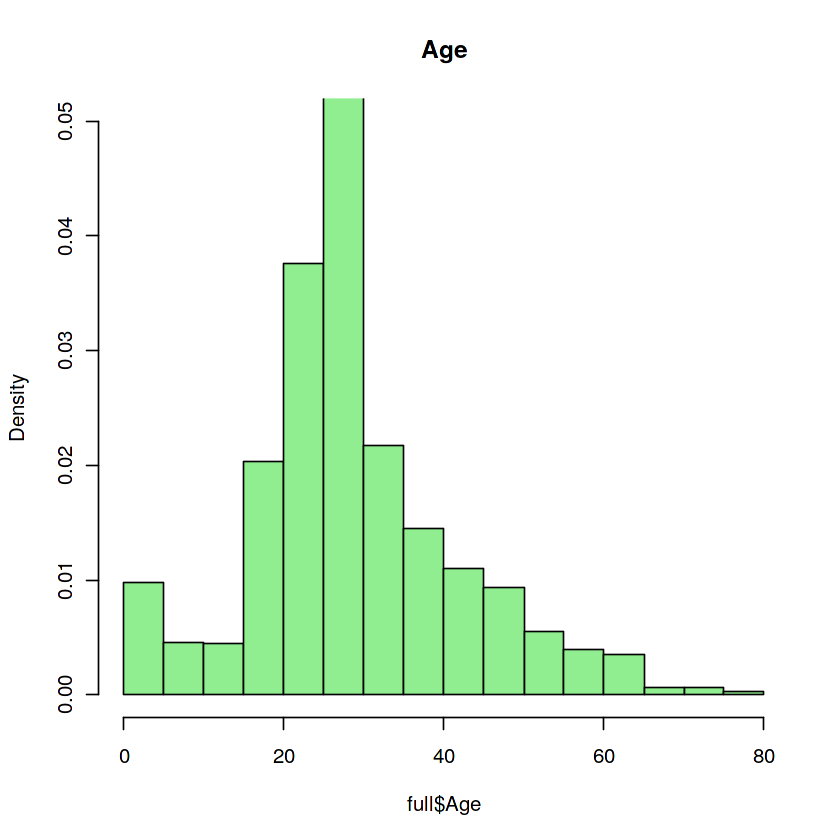

In [62]:
hist(full$Age, freq=F, main='Age',col='lightgreen', ylim=c(0,0.05))

# child : 18세 이하
# adult : 19세 이상 64세 이하
# senior : 65세 이상

full$Age <- ifelse(full$Age <= 18, "child",
                   ifelse(full$Age > 18 & full$Age <= 64, "adult","senior"))

## 5.6 Ticket

Ticket 변수를 이용하여 GroupSize 파생변수를 생성한다

In [63]:
length(unique(full$Ticket))

[1] 929

In [64]:
head(full$Ticket)

[1] "A/5 21171"        "PC 17599"         "STON/O2. 3101282" "113803"          
[5] "373450"           "330877"

In [65]:
full  %>%  arrange(Ticket) #같은 티켓인데도 불구하고 Family가 single, 친구등과 같이 온것으로 유추

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Fsize,Familysize,Deck
258,1,1,"Cherry, Miss. Gladys",1,adult,0,0,110152,86.5000,S,Miss,1,single,B
505,1,1,"Maioni, Miss. Roberta",1,child,0,0,110152,86.5000,S,Miss,1,single,B
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",1,adult,0,0,110152,86.5000,S,Officer,1,single,B
263,0,1,"Taussig, Mr. Emil",0,adult,1,1,110413,79.6500,S,Mr,3,small,E
559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,adult,1,1,110413,79.6500,S,Mrs,3,small,E
586,1,1,"Taussig, Miss. Ruth",1,child,0,2,110413,79.6500,S,Miss,3,small,E
111,0,1,"Porter, Mr. Walter Chamberlain",0,adult,0,0,110465,52.0000,S,Mr,1,single,C
476,0,1,"Clifford, Mr. George Quincy",0,adult,0,0,110465,52.0000,S,Mr,1,single,A
1227,NA,1,"Maguire, Mr. John Edward",0,adult,0,0,110469,26.0000,S,Mr,1,single,C
1050,NA,1,"Borebank, Mr. John James",0,adult,0,0,110489,26.5500,S,Mr,1,single,D


In [66]:
full$TravelGroup <- NA

In [67]:
full <- (transform(full, TravelGroup = match(Ticket, unique(Ticket))))

In [68]:
full <- full %>% 
            group_by(TravelGroup) %>% 
            mutate(GroupSize = n()) %>%
            ungroup()

In [69]:
full  %>% arrange(Ticket)  %>% head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Fsize,Familysize,Deck,TravelGroup,GroupSize
258,1,1,"Cherry, Miss. Gladys",1,adult,0,0,110152,86.50,S,Miss,1,single,B,231,3
505,1,1,"Maioni, Miss. Roberta",1,child,0,0,110152,86.50,S,Miss,1,single,B,231,3
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",1,adult,0,0,110152,86.50,S,Officer,1,single,B,231,3
263,0,1,"Taussig, Mr. Emil",0,adult,1,1,110413,79.65,S,Mr,3,small,E,235,3
559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,adult,1,1,110413,79.65,S,Mrs,3,small,E,235,3
586,1,1,"Taussig, Miss. Ruth",1,child,0,2,110413,79.65,S,Miss,3,small,E,235,3


# 6. Predict

## 6.1 변수선택
Pclass, Sex, Age, Fare, Embarked, Title, Fsize, GroupSize, Deck

In [70]:
str(full)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  17 variables:
 $ PassengerId: num  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 156 287 531 430 23 826 775 922 613 855 ...
 $ Sex        : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Age        : chr  "adult" "adult" "adult" "adult" ...
 $ SibSp      : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ Fsize      : num  2 2 1 2 1 1 1 5 3 2 ...
 $ Familysize : Factor w/ 3 levels "large","single",..: 3 3 2 3 2 2 2 1 3 3 ...
 $ Deck       :

In [71]:
#범주화 안된 변수들 범주화 처리
factor_vars <- c('Age','GroupSize','Deck')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))
                            
#Fare log변환
full$Fare=log1p(full$Fare)

In [72]:
full=full  %>%  select(-c(1,4,7,8,9,13,16))
str(full)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  10 variables:
 $ Survived  : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass    : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex       : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Age       : Factor w/ 3 levels "adult","child",..: 1 1 1 1 1 1 1 2 1 2 ...
 $ Fare      : num  2.11 4.28 2.19 3.99 2.2 ...
 $ Embarked  : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title     : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ Familysize: Factor w/ 3 levels "large","single",..: 3 3 2 3 2 2 2 1 3 3 ...
 $ Deck      : Factor w/ 11 levels "A","B","C","D",..: 11 3 11 3 11 11 5 11 11 10 ...
 $ GroupSize : Factor w/ 9 levels "1","2","3","4",..: 1 2 1 2 1 1 2 5 3 2 ...


In [73]:
train <-full  %>% filter(is.na(Survived)==FALSE)
test <-full  %>% filter(is.na(Survived)==TRUE)

In [74]:
train_label <- as.numeric(train$Survived)-1
test_label <- test$Survived


x_train<- model.matrix(~.-1, data = train[,-1]) %>% data.frame

x_test <- model.matrix(~.-1, data = test[,-1]) %>% data.frame

# XGBOOST

## (1) cross vaildation

In [75]:
library(xgboost)


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [76]:
dtrain <- xgb.DMatrix(data = as.matrix(x_train), label=train_label)
dtest <- xgb.DMatrix(data = as.matrix(x_test))

In [77]:
set.seed(2019)
param <- list(objective   = "binary:logistic",
              eval_metric = "auc",
              max_depth   = 6,
              eta         = 0.01,
              gammma      = 0,
              subsamle    = 0.5,
              colsample_bytree = 0.5,
              min_child_weight = 5)
# xgb_cv <- xgb.cv(params  = param,
#               data    = dtrain,
#               nrounds = 5000,
#               nfold   = 5,
#               nthread = -1,
#               silent = 1,
#               print_every_n = 100,
#               verbose = 0)

In [78]:
# best=xgb_cv$best_iteration  # optimal number of tree

In [79]:
# auc=xgb_cv$evaluation_log
# auc  %>% filter(test_auc_mean==max(auc[,4]))

In [80]:
xgb <- xgb.train(params  = param,
              data    = dtrain,
              nrounds = 4790,
              silent = 1,
              print_every_n = 100,
              verbose = 0)

## (2) Threshold

In [81]:
library(caret)
set.seed(123)
split <- createDataPartition(y = train$Survived,p = 0.7,list = FALSE)

new_train <- train[split,] 
new_test <- train[-split,]


x_label= as.numeric(new_train$Survived)-1
y_label= as.numeric(new_test$Survived)-1

new_train2 <- model.matrix(~.-1, data = new_train[,-1]) %>% data.frame
new_test2 <- model.matrix(~.-1, data = new_test[,-1]) %>% data.frame

dtrain2 <- xgb.DMatrix(data = as.matrix(new_train2), label=x_label)
dtest2 <- xgb.DMatrix(data = as.matrix(new_test2), label=y_label)

Loading required package: lattice
Warning message:
“replacing previous import ‘ggplot2::empty’ by ‘plyr::empty’ when loading ‘caret’”

In [82]:
xgb2 <- xgb.train(params  = param,
              data    = dtrain2,
              nrounds = 4790,
              silent = 1,
              print_every_n = 100,
              verbose = 0)

In [83]:
set.seed(2019)
XGB_pred2 <- predict(xgb2, dtest2)

In [84]:
head(XGB_pred2,10)
head(new_test$Survived,10)

[1] 0.53730828 0.79218662 0.89175695 0.05093927 0.05036978 0.27953506
 [7] 0.80083972 0.05965833 0.12256902 0.21125214

[1] 1 1 1 0 0 0 1 0 1 1
Levels: 0 1

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall



ERROR: Error in auc(new_test$Survived, XGB_pred): object 'XGB_pred' not found


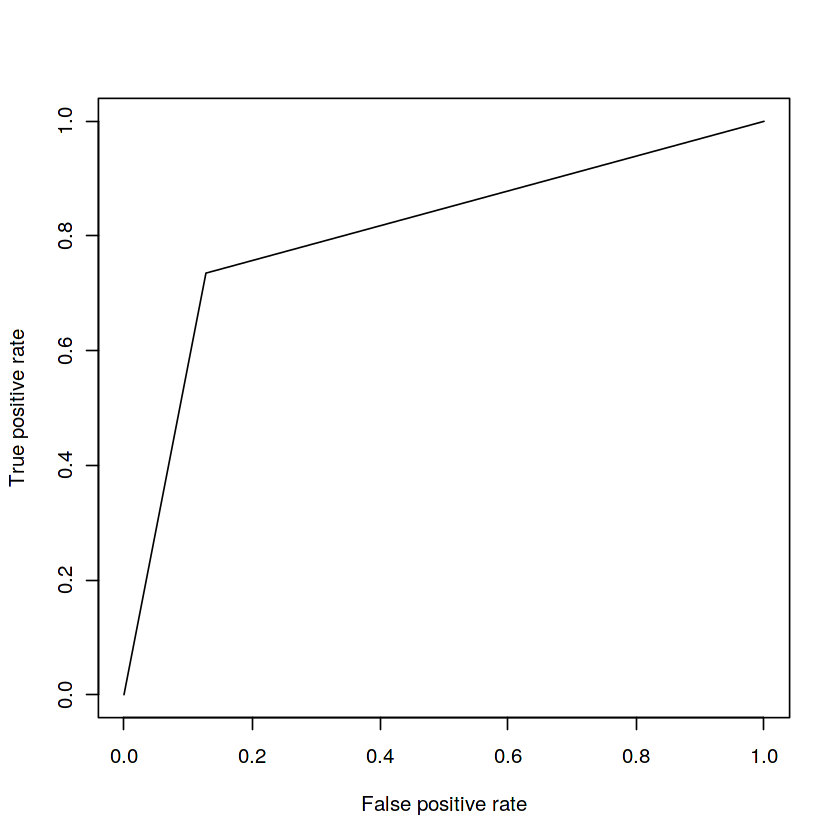

In [85]:
set.seed(2019)
XGB_pred2 <- predict(xgb2, dtest2)
XGB_pred2 <- ifelse(XGB_pred2>=0.5,1,0)
#plot ROC 
library(ROCR) 
library(Metrics)
pr <- prediction(XGB_pred2,new_test$Survived)
perf <- performance(pr,measure = "tpr",x.measure = "fpr") 
plot(perf) > auc(new_test$Survived,XGB_pred) #0.8109

In [86]:
auc(new_test$Survived,XGB_pred2)

[1] 0.8036227

logical(0)

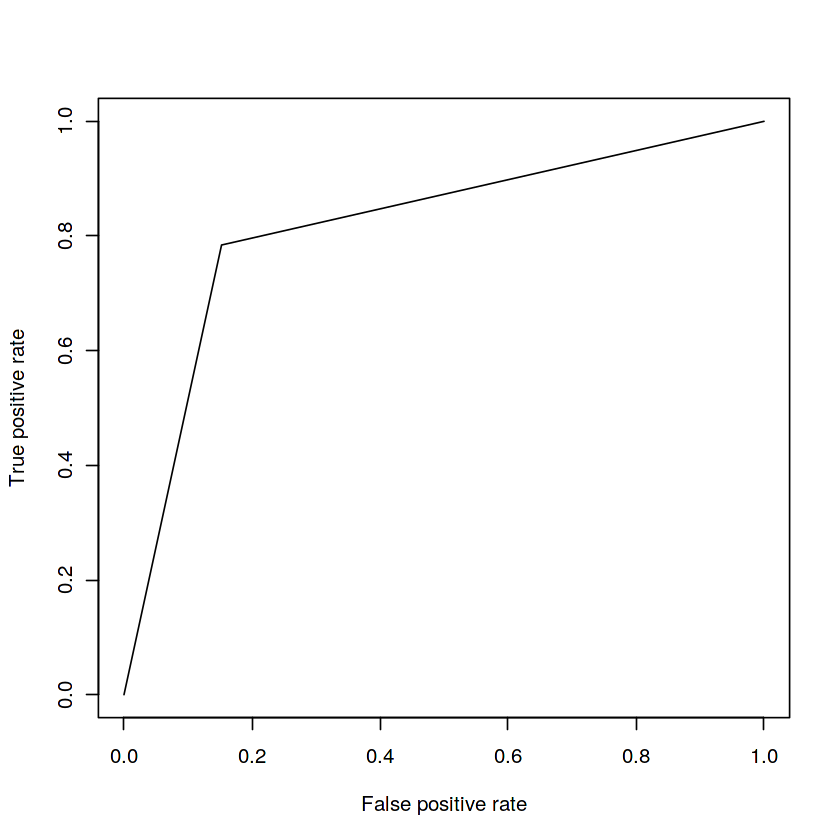

In [87]:
set.seed(2019)
XGB_pred2 <- predict(xgb2, dtest2)
XGB_pred2 <- ifelse(XGB_pred2>=0.4,1,0)
#plot ROC 
library(ROCR) 
library(Metrics)
pr <- prediction(XGB_pred2,new_test$Survived)
perf <- performance(pr,measure = "tpr",x.measure = "fpr") 
plot(perf) > auc(new_test$Survived,XGB_pred2) #0.815

In [88]:
auc(new_test$Survived,XGB_pred2)

[1] 0.8159374

* 임계값을 0.4로 했을때가 성능이 더 좋음

## (3) Submission

In [89]:
set.seed(2019)
XGB_pred <- predict(xgb, dtest)

In [90]:
XGB_pred <- ifelse(XGB_pred>=0.4,1,0)

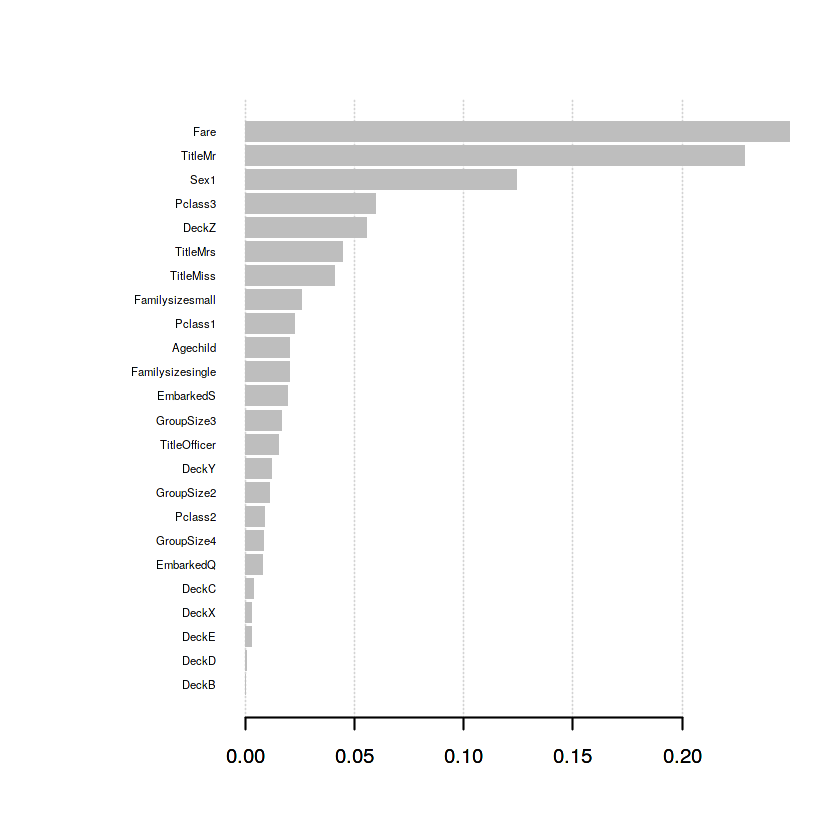

In [91]:
xgb.importance(colnames(dtrain), model = xgb) %>% 
  xgb.plot.importance(top_n = 30)

In [92]:
submission_xgb <- read.csv('../input/sample_submission.csv')
submission_xgb$Survived <- XGB_pred
write.csv(submission_xgb, file='submission_xgb.csv', row.names = F)